# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2020


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import skimage

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/cs445_projects/proj2/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .

import utils

cp: /content/drive/My Drive/cs445_projects/proj2/utils.py: No such file or directory
cp: /content/drive/My Drive/cs445_projects/proj2/samples: No such file or directory


In [4]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [5]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    shape = sample.shape

    res = np.array([[[0]*3]*out_size]*out_size)
    print(shape)
    print(res.shape)


    
    for l in range(out_size // patch_size):
        for m in range(out_size // patch_size):
            i = np.random.random_integers(0, shape[1] - patch_size)
            j = np.random.random_integers(0, shape[0] - patch_size)
            for n in range(patch_size):
                for o in range(patch_size):
                    res[l * patch_size + n][m * patch_size + o] = sample[i + n][j + o]
                

        

    return res
    




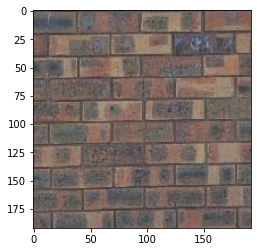

(192, 192, 3)
(200, 200, 3)


/var/folders/2d/mqx8_d3j7sz1dwfnhtqnd3c00000gn/T/ipykernel_68841/3490893239.py:20: DeprecationWarning: This function is deprecated. Please call randint(0, 177 + 1) instead
  i = np.random.random_integers(0, shape[1] - patch_size)
/var/folders/2d/mqx8_d3j7sz1dwfnhtqnd3c00000gn/T/ipykernel_68841/3490893239.py:21: DeprecationWarning: This function is deprecated. Please call randint(0, 177 + 1) instead
  j = np.random.random_integers(0, shape[0] - patch_size)
/var/folders/2d/mqx8_d3j7sz1dwfnhtqnd3c00000gn/T/ipykernel_68841/2468768156.py:12: UserWarning: part1.jpeg is a low contrast image
  skimage.io.imsave("part1.jpeg", res)
Lossy conversion from int64 to uint8. Range [0, 180]. Convert image to uint8 prior to saving to suppress this warning.


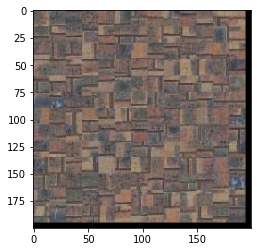

In [6]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15 
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)
    plt.savefig("res.png")
    skimage.io.imsave("part1.jpeg", res)

### Part II: Overlapping Patches (30 pts)

In [7]:
def choose_sample(cost_map, tol):
    
    
    cost = cost_map.flatten()
    
    ind = np.argsort(cost)[:tol]
    
    res = ind[np.random.randint(tol)]

    return divmod(res, len(cost_map[0]))

In [8]:
def ssd_patch(temp, sample, patch_size, overlap, case):

    #cost = np.zeros((sample.shape[0] - patch_size + 1, sample.shape[1] - patch_size + 1))
    I = sample
    T = temp
    M = np.zeros((patch_size, patch_size))
    if case == 0:
        M[: , :overlap] = 1
    elif case == 1:
        M[:overlap, :] = 1
    else:
        M[:overlap, :overlap] = 1
    for i in range(3):
        if i == 0:
            cost = ((M*T[:,:,i])**2).sum() - 2 * cv2.filter2D(I[:,:,i], ddepth=-1, kernel = M*T[:,:,i]) + cv2.filter2D(I[:,:,i] ** 2, ddepth=-1, kernel=M)
        else:
            cost += ((M*T[:,:,i])**2).sum() - 2 * cv2.filter2D(I[:,:,i], ddepth=-1, kernel = M*T[:,:,i]) + cv2.filter2D(I[:,:,i] ** 2, ddepth=-1, kernel=M)
    return cost

In [9]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsi
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    shape = sample.shape
    sample = sample/255.0


    
    res = np.zeros((out_size, out_size, 3), np.float32)
    print(shape)

    #assign the first 
    i = np.random.randint(0, shape[1] - patch_size)
    j = np.random.randint(0, shape[0] - patch_size)

    res[0:patch_size, 0:patch_size] = sample[i:i+patch_size, j:j+patch_size]
    # plt.imshow(res)
    # plt.savefig("part2.png")
    # return
    add_l = patch_size - overlap
    half = patch_size//2
    
    case = 2
    for l in range(((out_size - patch_size) // (patch_size - overlap))):
        for m in range(((out_size - patch_size) // (patch_size - overlap))):
            if l == 0 and m == 0:
                continue
            if l == 0: # first row
                case = 0
            elif m == 0: # first col
                case = 1
            
            cost_map = ssd_patch(res[l*add_l: l*add_l+patch_size, m*add_l:m*add_l+patch_size], sample, patch_size, overlap, case)

            edge = patch_size // 2
            cost_map[0:edge] = np.inf
            cost_map[-edge:] = np.inf
            cost_map[:,0:edge] = np.inf
            cost_map[:,-edge:] = np.inf
            x, y = choose_sample(cost_map, tol)
            
            
            res[l*add_l:l*add_l+patch_size, m*add_l:m*add_l+patch_size] = sample[x-half:x-half+patch_size, y-half:y-half+patch_size]
            
    return res     

            



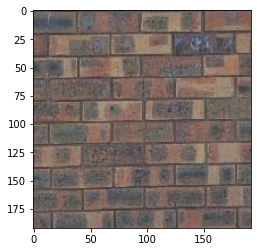

(192, 192, 3)


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


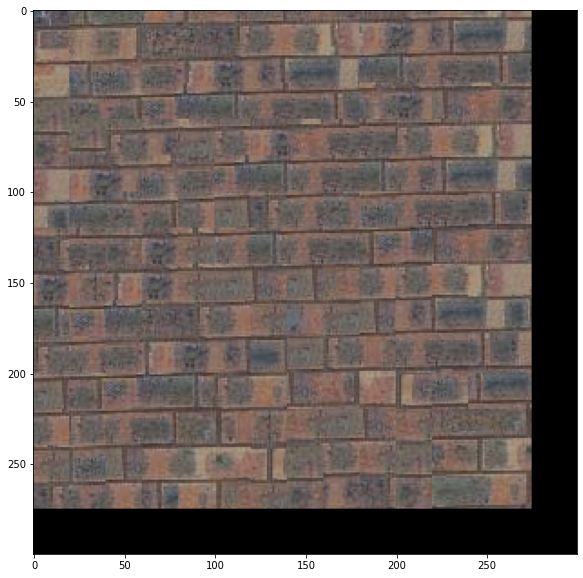

In [10]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300 # change these parameters as needed
patch_size = 35
overlap = 15
tol = 3
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.imshow(res)
    skimage.io.imsave("part2.jpeg", res)

### Part III: Seam Finding (20 pts)


In [11]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [12]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    shape = sample.shape
    sample = sample/255.0


    
    res = np.zeros((out_size, out_size, 3), np.float32)
    print(shape)

    #assign the first 
    i = np.random.randint(0, shape[1] - patch_size)
    j = np.random.randint(0, shape[0] - patch_size)

    res[0:patch_size, 0:patch_size] = sample[i:i+patch_size, j:j+patch_size]
    # plt.imshow(res)
    # plt.savefig("part2.png")
    # return
    add_l = patch_size - overlap
    half = patch_size//2

    case = 2
    for l in range(((out_size - patch_size) // (patch_size - overlap))):
        for m in range(((out_size - patch_size) // (patch_size - overlap))):
            if l == 0 and m == 0:
                continue
            if l == 0: # first row
                case = 0
            elif m == 0: # first col
                case = 1
            
            cost_map = ssd_patch(res[l*add_l: l*add_l+patch_size, m*add_l:m*add_l+patch_size], sample, patch_size, overlap, case)

            edge = patch_size // 2
            cost_map[0:edge] = np.inf
            cost_map[-edge:] = np.inf
            cost_map[:,0:edge] = np.inf
            cost_map[:,-edge:] = np.inf
            x, y = choose_sample(cost_map, tol)
            
            if m > 0:
                left_p = np.sum(res[l*add_l:l*add_l+patch_size, m*add_l:m*add_l+overlap], axis = -1)
                right_p = np.sum(sample[x-half:x-half+patch_size, y-half:y-half+overlap], axis = -1)
                ver_cut = utils.cut((left_p - right_p).T ** 2).T
            if l > 0:
                top_p = np.sum(res[l*add_l:l*add_l+overlap, m*add_l:m*add_l+patch_size], axis = -1)
                bot_p = np.sum(sample[x-half:x-half+overlap, y-half:y-half+patch_size], axis = -1)
                hor_cut = utils.cut((top_p - bot_p) ** 2)
            if l == 0:
                mask = np.ones((patch_size, patch_size, 3))
                mask[:,0:overlap, 0] = ver_cut
                mask[:,0:overlap, 1] = ver_cut
                mask[:,0:overlap, 2] = ver_cut
                inverse_mask = np.where(mask == 0, 1, 0)
                res[l*add_l:l*add_l+patch_size, m*add_l:m*add_l+patch_size] *= inverse_mask
                res[l*add_l:l*add_l+patch_size, m*add_l:m*add_l+patch_size] += (mask * sample[x-half:x-half+patch_size, y-half:y-half+patch_size].copy())
                
            elif m == 0:
                mask = np.ones((patch_size, patch_size, 3))
                mask[0:overlap,:, 0] = hor_cut
                mask[0:overlap,:, 1] = hor_cut
                mask[0:overlap,:, 2] = hor_cut
                inverse_mask = np.where(mask == 0, 1, 0)
                res[l*add_l:l*add_l+patch_size, m*add_l:m*add_l+patch_size] *= inverse_mask
                res[l*add_l:l*add_l+patch_size, m*add_l:m*add_l+patch_size] += (mask * sample[x-half:x-half+patch_size, y-half:y-half+patch_size].copy())  
                
            else:
                mask = np.ones((patch_size, patch_size, 3))
                mask[0:overlap,:, 0] = hor_cut
                mask[0:overlap,:, 1] = hor_cut
                mask[0:overlap,:, 2] = hor_cut
                mask_1 = np.ones((patch_size, patch_size, 3))
                mask_1[:,0:overlap, 0] = ver_cut
                mask_1[:,0:overlap, 1] = ver_cut
                mask_1[:,0:overlap, 2] = ver_cut
                mask = np.logical_and(mask, mask_1)
                inverse_mask = np.where(mask == 0, 1, 0)
                res[l*add_l:l*add_l+patch_size, m*add_l:m*add_l+patch_size] *= inverse_mask
                res[l*add_l:l*add_l+patch_size, m*add_l:m*add_l+patch_size] += (mask * sample[x-half:x-half+patch_size, y-half:y-half+patch_size].copy())    
        
                
    return res  
    


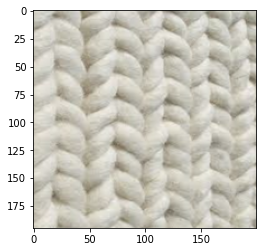

(195, 200, 3)


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


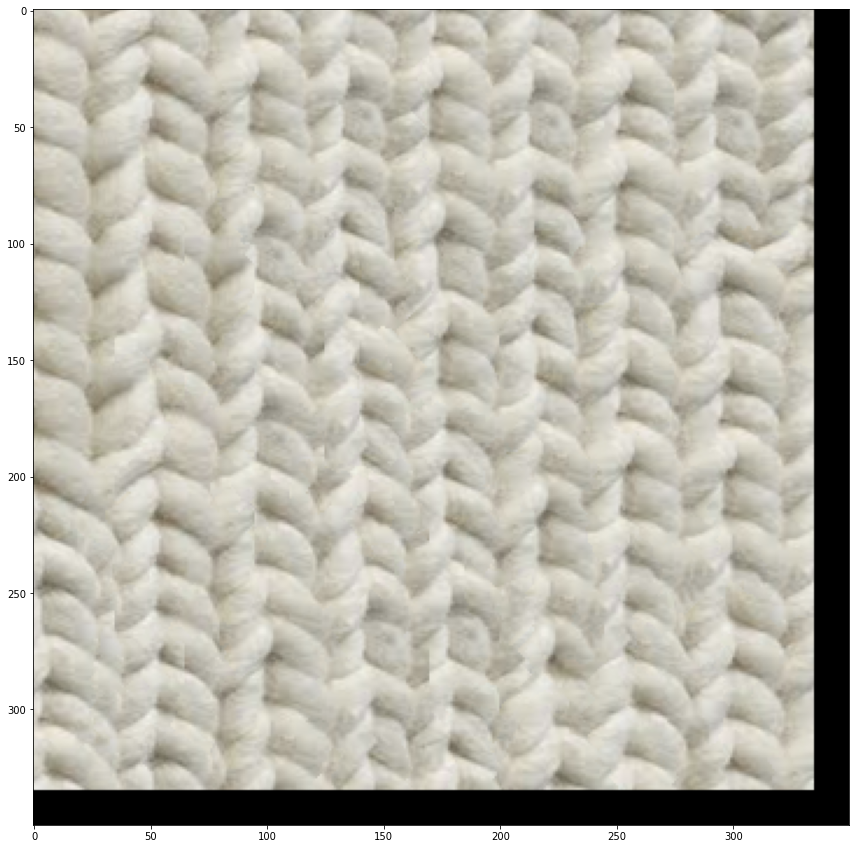

In [14]:
sample_img_fn = 'samples/texture.png' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 350 # change these parameters as needed
patch_size = 35
overlap = 20
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(15,15))
    plt.imshow(res)
    skimage.io.imsave("part3.jpeg", res)

### part IV: Texture Transfer (30 pts)

In [15]:
def ssd_transfer(temp, sample, patch_size):
        I = sample
        T = temp
        M = np.ones((patch_size, patch_size))
        cost = 0
        
        cost = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
        return cost

In [16]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    # copy = guidance_img.copy()
    # hsv = cv2.cvtColor(copy, cv2.COLOR_RGB2HSV)
    # value = 1 #whatever value you want to add
    # for i in range(len(copy)):
    #     for j in range(len(copy[0])):
    #         if np.sum(copy[i][j], axis=-1) < 50:
    #             copy[i][j][0] += 20
    #             copy[i][j][1] += 20
    #             copy[i][j][2] += 20
    # copy = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    # plt.imshow(copy, cmap="gray")
    # plt.savefig("copy.png")
    texture_blur = cv2.GaussianBlur(sample,  (21, 21), 2)
    guidance_blur = cv2.GaussianBlur(guidance_im, (21, 21), 2)
    texture_blur = cv2.cvtColor(texture_blur, cv2.COLOR_RGB2GRAY)/255.0
    guidance_blur = cv2.cvtColor(guidance_blur, cv2.COLOR_RGB2GRAY)/255.0
    
    plt.imshow(texture_blur, cmap="gray")
    plt.savefig("blur1.png")
    plt.imshow(guidance_blur, cmap="gray")
    plt.savefig("blur2.png")
    


    shape = sample.shape

    sample = sample/255.0
    guidance_im = guidance_im/255.0/2

    g_shape = guidance_im.shape

    res = np.zeros((g_shape[0], g_shape[1], 3), np.float32)
    
    half = patch_size//2
    cost_first = ssd_transfer(guidance_blur[0:patch_size, 0:patch_size], texture_blur, patch_size)
    

    edge = patch_size // 2
    cost_first[0:edge] = np.inf
    cost_first[-edge:] = np.inf
    cost_first[:,0:edge] = np.inf
    cost_first[:,-edge:] = np.inf
    x, y = choose_sample(cost_first, 10)
    res[0:patch_size, 0:patch_size] = sample[x-half:x-half+patch_size, y-half:y-half+patch_size]
            
    # plt.imshow(res)
    # plt.savefig("start.png")
    # return res
    add_l = patch_size - overlap
    half = patch_size//2
    case = 2
    for l in range(((g_shape[0] - patch_size) // (patch_size - overlap))):
        for m in range(((g_shape[1] - patch_size) // (patch_size - overlap))):
            if l == 0 and m == 0:
                continue
            if l == 0: # first row
                case = 0
            elif m == 0: # first col
                case = 1
            
            cost_map_1 = ssd_patch(res[l*add_l: l*add_l+patch_size, m*add_l:m*add_l+patch_size], sample, patch_size, overlap, case)
            cost_map_2 = ssd_transfer(guidance_blur[l*add_l: l*add_l+patch_size, m*add_l:m*add_l+patch_size], texture_blur, patch_size)
            cost_map = alpha*cost_map_1 + (1-alpha)*cost_map_2
            edge = patch_size // 2
            cost_map[0:edge] = np.inf
            cost_map[-edge:] = np.inf
            cost_map[:,0:edge] = np.inf
            cost_map[:,-edge:] = np.inf
            x, y = choose_sample(cost_map, tol)

            if m > 0:
                left_p = np.sum(res[l*add_l:l*add_l+patch_size, m*add_l:m*add_l+overlap], axis = -1)
                right_p = np.sum(sample[x-half:x-half+patch_size, y-half:y-half+overlap], axis = -1)
                ver_cut = utils.cut((left_p - right_p).T ** 2).T
            
            if l > 0:
                top_p = np.sum(res[l*add_l:l*add_l+overlap, m*add_l:m*add_l+patch_size], axis = -1)
                bot_p = np.sum(sample[x-half:x-half+overlap, y-half:y-half+patch_size], axis = -1)
                hor_cut = utils.cut((top_p - bot_p) ** 2)
            if l == 0:
                mask = np.ones((patch_size, patch_size, 3))
                mask[:,0:overlap, 0] = ver_cut
                mask[:,0:overlap, 1] = ver_cut
                mask[:,0:overlap, 2] = ver_cut
            elif m == 0:
                mask = np.ones((patch_size, patch_size, 3))
                mask[0:overlap,:, 0] = hor_cut
                mask[0:overlap,:, 1] = hor_cut
                mask[0:overlap,:, 2] = hor_cut
            else:
                mask = np.ones((patch_size, patch_size, 3))
                mask[0:overlap,:, 0] = hor_cut
                mask[0:overlap,:, 1] = hor_cut
                mask[0:overlap,:, 2] = hor_cut
                mask_1 = np.ones((patch_size, patch_size, 3))
                mask_1[:,0:overlap, 0] = ver_cut
                mask_1[:,0:overlap, 1] = ver_cut
                mask_1[:,0:overlap, 2] = ver_cut
                mask = np.logical_and(mask, mask_1)

            inverse_mask = np.where(mask == 0, 1, 0)
            res[l*add_l:l*add_l+patch_size, m*add_l:m*add_l+patch_size] *= inverse_mask
            res[l*add_l:l*add_l+patch_size, m*add_l:m*add_l+patch_size] += (mask * sample[x-half:x-half+patch_size, y-half:y-half+patch_size].copy())   
    return res  
    
    

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


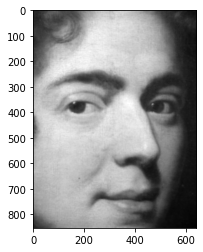

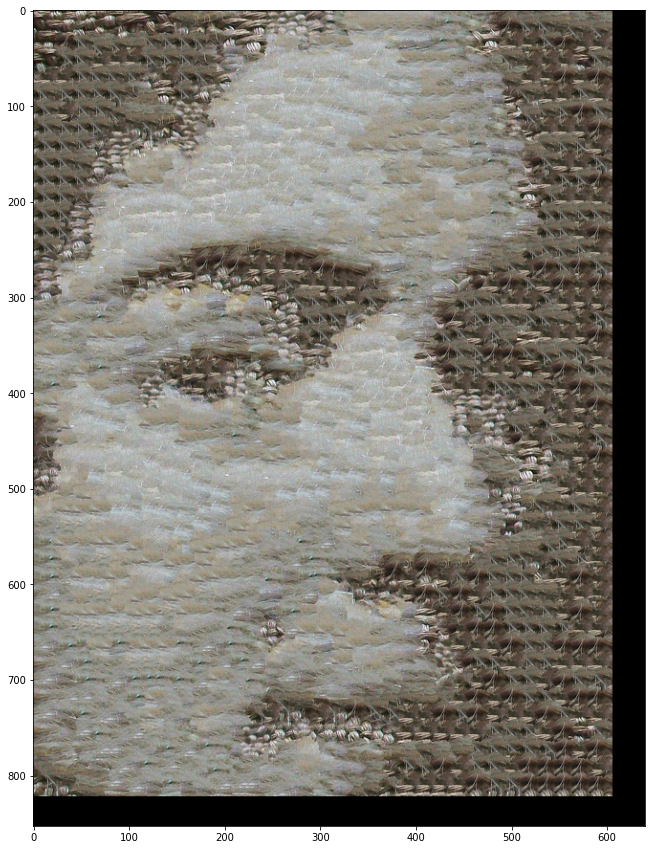

In [19]:
# load/process appropriate input texture and guidance images
texture_img_src = 'samples/part4_1.jpeg' # feel free to change
texture_img = cv2.cvtColor(cv2.imread(texture_img_src), cv2.COLOR_BGR2RGB)
# plt.imshow(texture_img)
# plt.savefig("part5.png")

guidance_img_src = 'samples/part4_face.jpeg' # feel free to change
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_src), cv2.COLOR_BGR2RGB)
# plt.imshow(guidance_img)
# plt.savefig("part4.png")

# plt.imshow(guidance_blur, cmap='gray')
# plt.savefig("part4.png")
# plt.imshow(texture_blur, cmap='gray')
# plt.savefig("part5.png")

patch_size = 30
overlap = 12
tol = 2
alpha = 0.4
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

plt.figure(figsize=(15,15))
plt.imshow(res)
plt.savefig("last.png")
skimage.io.imsave("last.png", res)

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).